In [21]:
# function_list = ['s', 'i', 'r', 'ps', 'pi', 'pr']
function_list = ['s', 'i', 'ps', 'pi']
variable_list = ['t','x']

from clspde.solution import lp as l

def lp(line, function_list=function_list, variable_list = variable_list):
    res = l(line, function_list, variable_list)
    return lambda u_loc, u_bas, x, x_loc: eval(res)
    
#simple direct problem solving

import matplotlib.pyplot as plt

from clspde.solution import Solution
from clspde.basis import Basis
import itertools
import numpy as np

a = 1
b = 1

eps = 0.05

beta = 1
gamma = 0.15

d1 = 0
d2 = 10


power = 4
params = {
    'n_dims': 2,
    'dim_sizes': np.array([3, 3]),
    'area_lims': np.array([[0,0.1], [0,1]]),
    'power': power,
    'basis': Basis(power),
    # 'n_funcs': 6,
     'n_funcs': 4,
}
sol = Solution(**params)

w = 1
k1 = 10
k2 = 0.5
border_weight = 100
no_need_weight = 0


def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))


connect_points = np.array([[-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],])
                            
border_points = connect_points

colloc_left_operators = [
    #KFP s
    lp('(d/dt) s - eps * (d/dx)^2 s + beta * ( s * &&i + &&s * i ) -' +
    '( (d/dx) s * (d/dx) &&ps + (d/dx) &&s * (d/dx) ps +' +
    ' s * (d/dx)^2 &&ps + &&s * (d/dx)^2 ps )'),
    #KFP i
    lp('(d/dt) i - eps * (d/dx)^2 i - beta * ( s * &&i + &&s * i ) +' +
    'gamma * i -' +
    '( (d/dx) i * (d/dx) &&pi + (d/dx) &&i * (d/dx) pi +' +
    ' i * (d/dx)^2 &&pi + &&i * (d/dx)^2 pi )'),
    #KFP r
    # lp('(d/dt) r - eps * (d/dx)^2 r - gamma * i -' +
    # '( (d/dx) r * (d/dx) &pr + (d/dx) &r * (d/dx) pr +' +
    # ' r * (d/dx)^2 &pr + &r * (d/dx)^2 pr )'),
    #HJB ps
    lp('- (d/dt) ps - eps * (d/dx)^2 ps +' +
    'beta*( i * ( &&ps - &&pi ) + &&i * ( ps - pi ))+' +
    '( (d/dx) ps * (d/dx) &&ps )'),
    #HJB pi
    lp('- (d/dt) pi - eps * (d/dx)^2 pi -' +
    'beta*( s * ( &&ps - &&pi ) + &&s * ( ps - pi ))+' +
    #'gamma * ( pi - pr ) + ' + #add when equation for r is added !!!
    'gamma * ( pi ) + ' + 
    '( (d/dx) pi * (d/dx) &&pi )'),
    #HJB pr
    # lp('- (d/dt) pr - eps * (d/dx)^2 pr +' +
    # '( (d/dx) pr * (d/dx) &pr )'),
    ]
colloc_right_operators = [
    lp('(d/dx) &s * (d/dx) &ps - (d/dx) &s * (d/dx) &&ps - (d/dx) &&s * (d/dx) &ps ' +
       '+ &s * (d/dx)^2 &ps - &s * (d/dx)^2 &&ps - &&s * (d/dx)^2 &ps ' + 
       '+ beta * (- &s * &i + &s * &&i + &&s * &i )'),
    lp('(d/dx) &i * (d/dx) &pi - (d/dx) &i * (d/dx) &&pi - (d/dx) &&i * (d/dx) &pi '+
        '+ &i * (d/dx)^2 &pi - &i * (d/dx)^2 &&pi - &&i * (d/dx)^2 &pi '+
        '+ beta *( &s * &i - &s * &&i - &&s * &i )'),
    # lp('- (d/dx) &r * (d/dx) &pr - &r * (d/dx)^2 &pr'),
    lp('-beta *( &i * ( &ps - &pi ) - &i * ( &&ps - &&pi ) - &&i * ( &ps - &pi )) '+
       '- ( (d/dx) &ps )**2/2 + ( (d/dx) &ps * (d/dx) &&ps ) '+
       '+ d1'),
    lp('beta * &s * ( &ps - &pi ) - beta * &s * ( &&ps - &&pi ) - beta * &&s * ( &ps - &pi )'+
       '- ( (d/dx) &pi )**2/2 + ( (d/dx) &pi * (d/dx) &&pi ) '+
       '- d1'),
    # lp('( (d/dx) &pr )**2/2'),
    ]


def initial_state(x):
    t, x = x
    sm_x = 3*x-1
    if (x<2/3 and x>1/3):
        return np.array([0.97, 0.02, 0.01]) * 3 * 12 * (sm_x**2) *(1-sm_x)
    else:
        return np.array([0,0,0])

def terminal_state(x):
    sm_x = 3*x-1
    if (x<2/3 and x>1/3):
        return np.array([0, 0., 0.])* 12*sm_x*(1-sm_x)**2 *3
    else:
        return [0,0,0]

def Bx(x):
    #border condition for x
    return int((x[1]==sol.area_lims[1,0]) or (x[1]==sol.area_lims[1,1]))

def BtI(x):
    #border condition Initial for t
    return int(x[0]==sol.area_lims[0,0])

def BtT(x):
    #border condtition Terminal for t
    return int(x[0]==sol.area_lims[0,1])

border_left_operators = [
    lp('Bx(x) * s'),
    lp('Bx(x) * i'),
    # lp('Bx(x) * r'),

    lp('Bx(x) * (d/dx) s'),
    lp('Bx(x) * (d/dx) i'),

    lp('Bx(x) * (d/dx) ps'),
    lp('Bx(x) * (d/dx) pi'),
    # lp('Bx(x) * pr'),

    lp('BtI(x) * s'),
    lp('BtI(x) * i'),
    # lp('BtI(x) * r'),
    lp('BtT(x) * ps'),
    lp('BtT(x) * ( pi - i *d2 )'),
    # lp('BtT(x) * pr'),
    ]

border_right_operators = [
    lp('Bx(x) * initial_state(x)[0]'),
    lp('Bx(x) * initial_state(x)[1]'),
    # lp('Bx(x) * initial_state(x)[2]'),
    lp('Bx(x) * 0'),
    lp('Bx(x) * 0'),
    
    lp('Bx(x) * 0'),
    lp('Bx(x) * 0'),
    # lp('Bx(x) * 0'),

    lp('BtI(x) * initial_state(x)[0]'),
    lp('BtI(x) * initial_state(x)[1]'),
    # lp('BtI(x) * initial_state(x)[2]'),
    lp('BtT(x) * (-terminal_state(x[1])[0])'),
    lp('BtT(x) * (-terminal_state(x[1])[1])'),
    # lp('BtT(x) * (-terminal_state(x[1])[2])'),
    ]

def f_collocation_points(N):
    points = np.zeros(N+1)
    h = 2/(N+1)
    points[0] = -1 + h/2
    for i in range(1, N+1):
        points[i] = points[i-1] + h
    return np.array(points).reshape(N+1,1)

c_p_1d = f_collocation_points(power).reshape(power+1)

colloc_points = np.array(list(itertools.product(c_p_1d, c_p_1d)))
connect_points = np.array([
                            [-1, 0.5], [1, 0.5],
                            [0.5, -1], [0.5, 1],
                            [-1, -0.5], [1, -0.5],
                            [-0.5, -1], [-0.5, 1],
                            [-1, 0], [1, 0],
                            [0, -1], [0, 1],
                            ])
border_points = connect_points
points=[colloc_points, connect_points ,border_points]

connect_left_operators = []
connect_right_operators = []

def dir(point: np.array) -> np.array:
    direction = (np.abs(point) == 1) * (np.sign(point))
    return np.array(direction, dtype=int)
for func_num in range(sol.n_funcs):
    # connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc),func_num) + np.sum(dir(x_loc))*int(abs(x_loc[1])==1)*u_bas([0,1],func_num)]
    # connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: u_bas(0*dir(x_loc),func_num) -  np.sum(dir(x_loc))*int(abs(x_loc[1])==1)*u_bas([0,1],func_num)]
    connect_left_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) + k2*np.sum(dir(x_loc))*u_bas([0,1],func_num) * np.prod(dir(np.array([0.5,1]))==[0,1])]
    connect_right_operators += [lambda _, u_bas, x, x_loc, func_num=func_num: k1*u_bas(0*dir(x_loc),func_num) -  k2*np.sum(dir(x_loc))*u_bas([0,1],func_num) * np.prod(dir(np.array([0.5,-1]))==[0,-1])]

colloc_ops = [colloc_left_operators, colloc_right_operators]
border_ops = [border_left_operators, border_right_operators]
connect_ops = [connect_left_operators, connect_right_operators]

iteration_dict = {'points':points,
        'colloc_ops':colloc_ops,
        'border_ops':border_ops,
       'connect_ops':connect_ops
}

sol.cells_coefs *= 0.0


Переформулировать условие на S компоненту, чтобы она отображала экономическую составляющую модели.

In [25]:
sol.cell_division(1)

In [26]:
import copy
k=100
n=20
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

def ev(sol, ts=ts, xs=xs):
    res_array = np.zeros((len(ts), len(xs)))
    for i in range(len(ts)):
        t = ts[i]
        for j in range(len(xs)):
            x = xs[j]
            res_array[i,j] = sol.eval(np.array([t,x]), [0,0])
    return res_array

new_eval=ev(sol)
division_counter = 0
print('Iter \t| ', 'Coefs diff','\t| ', 'Sol diff', '\t| ')
tab_prec = "%.5E"
for j in range(k):
    prev_eval = new_eval
    prev_coefs = copy.deepcopy(sol.cells_coefs)
    A, b = sol.global_solve(solver='np', return_system=True, **iteration_dict)
    new_eval = ev(sol)
    change = np.max(np.abs(prev_eval - new_eval))
    #print(j,' | ', np.max(np.abs(prev_coefs - sol.cells_coefs)),' | ', change)
    print(j,'\t| ', tab_prec % np.max(np.abs(prev_coefs - sol.cells_coefs)),'\t| ',tab_prec % change, '\t| ')
    if change < 1e-4:
        sol.plot2d()
        division_counter +=1
        sol.cell_division(1)#(division_counter % 2)
        if division_counter > 5:
            break


0  |  0.9520301993482152  |  1.4353590397394171
1  |  0.28633347739529935  |  0.21933761259136375
2  |  0.08153409301358278  |  0.08674846409705061
3  |  0.01738351900767776  |  0.014773927354727157
4  |  0.009494289223542562  |  0.00816951283071532
5  |  0.0052032774935484305  |  0.004481171342364226
6  |  0.00503216702819298  |  0.004209648033745683
7  |  0.003364231828946629  |  0.00268132785545383
8  |  0.0027802739573550284  |  0.002249874543840402
9  |  0.0020475719776702483  |  0.0016285873374566329


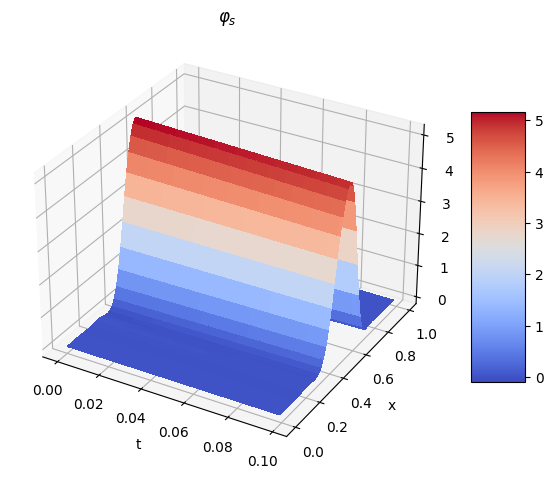

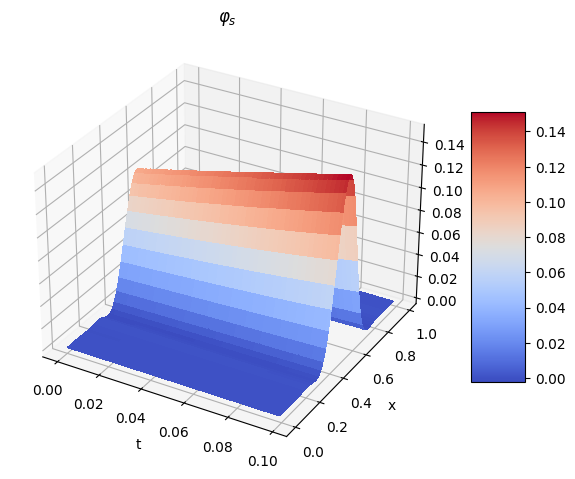

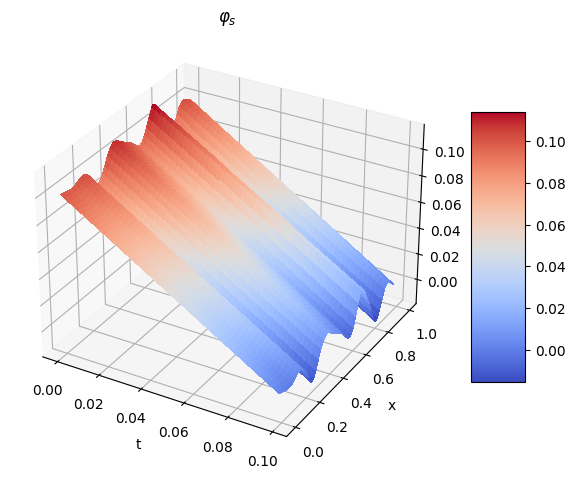

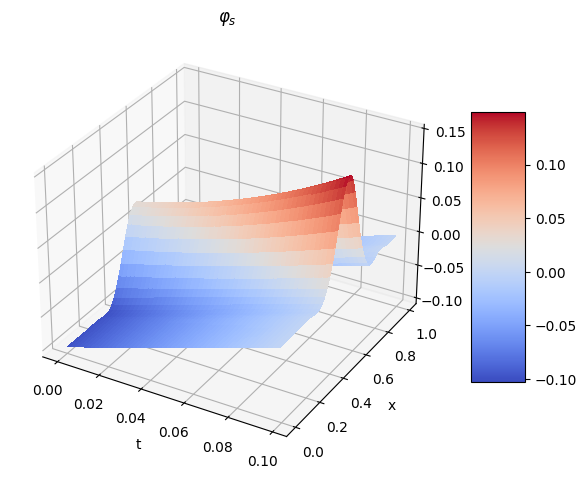

In [20]:
for i in range(sol.n_funcs):
    sol.plot2d(func_num=i, func_name="$\\varphi_s$")

In [ ]:
sol.cell_division(1)

In [199]:
import copy
k=100
n=100
small = 10**(-5)
ts = np.linspace(params['area_lims'][0,0],params['area_lims'][0,1] - small, n)
xs = np.linspace(params['area_lims'][1,0],params['area_lims'][1,1] - small, n)

res_array = np.zeros((len(ts), len(xs)))
for i in range(len(ts)):
    t = ts[i]
    for j in range(len(xs)):
        x = xs[j]
        res_array[i,j] = sol.eval(np.array([t,x]), [0,0], 1)



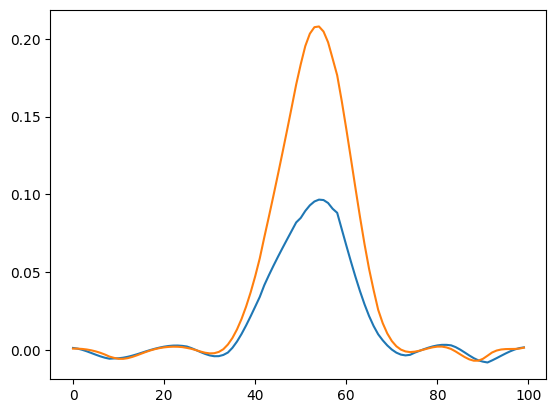

In [200]:
plt.plot(res_array[0])
plt.plot(res_array[-1])